In [682]:
from itertools import chain, combinations, permutations, product, pairwise
from math import prod, log
from copy import deepcopy
import networkx as nx
from fractions import Fraction
import json
from operator import add

def hs_array_to_fr(hs_array):
    return prod([pow(dims[d], hs_array[d]) for d in range(len(dims))])

def hs_array_to_cents(hs_array):
    return (1200 * log(hs_array_to_fr(hs_array), 2))

def expand_pitch(hs_array):
    expanded_pitch = list(hs_array)
    frequency_ratio = hs_array_to_fr(hs_array)
    if frequency_ratio < 1:
        while frequency_ratio < 1:
            frequency_ratio *= 2
            expanded_pitch[0] += 1
    elif frequency_ratio >= 2:
        while frequency_ratio >= 2:
            frequency_ratio *= 1/2
            expanded_pitch[0] += -1
    return tuple(expanded_pitch)

def expand_chord(chord):
    return tuple(expand_pitch(p) for p in chord)

def collapse_pitch(hs_array):
    collapsed_pitch = list(hs_array)
    collapsed_pitch[0] = 0
    return tuple(collapsed_pitch)

def collapse_chord(chord):
    return tuple(collapse_pitch(p) for p in chord)

def transpose_pitch(pitch, trans):
    return tuple(map(add, pitch, trans))

def transpose_chord(chord, trans):
    return tuple(transpose_pitch(p, trans) for p in chord)

def cent_difference(hs_array1, hs_array2):
    return hs_array_to_cents(hs_array2) - hs_array_to_cents(hs_array1)

def pitch_difference(hs_array1, hs_array2):
    return transpose_pitch(hs_array1, [p * -1 for p in hs_array2])

# this is modified for different chord sizes like original version
def grow_chords(chord, root, min_chord_size, max_chord_size):
    #this could use the tranpose_pitch function
    branches = [branch for alt in [-1, 1] for d in range(1, len(root)) if (branch:=(*(r:=root)[:d], r[d] + alt, *r[(d + 1):])) not in chord]
    subsets = chain.from_iterable(combinations(branches, r) for r in range(1, max_chord_size - len(chord) + 1))
    for subset in subsets:
        extended_chord = chord + subset
        if(len(extended_chord) < max_chord_size):
            for branch in subset:
                yield from grow_chords(extended_chord, branch, min_chord_size, max_chord_size)
        if(len(extended_chord) >= min_chord_size):
            yield tuple(sorted(extended_chord, key=hs_array_to_fr))

def chords(chord, root, min_chord_size, max_chord_size):
    # this will filter out the 4x dups of paths that are loops, there might be a faster way to test this
    return set(grow_chords(chord, root, min_chord_size, max_chord_size))

# this is very slow, I have an idea in mind that my be faster by simply growing the chords to max_chord_size + max_sim_diff
# technically at that point you have generated both chords and can get the second chord from the first
def edges(chords, min_symdiff, max_symdiff, max_chord_size):  

    def reverse_movements(movements):
        return {value['destination']:{'destination':key, 'cent_difference':value['cent_difference'] * -1} for key, value in movements.items()}

    def is_directly_tunable(intersection, diff):
        # this only works for now when intersection if one element - need to fix that
        return max([sum(abs(p) for p in collapse_pitch(pitch_difference(d, list(intersection)[0]))) for d in diff]) == 1

    for combination in combinations(chords, 2):
        [expanded_base, expanded_comp] = [expand_chord(chord) for chord in combination]
        edges = []
        transpositions = set(pitch_difference(pair[0], pair[1]) for pair in set(product(expanded_base, expanded_comp)))
        for trans in transpositions:
            expanded_comp_transposed = transpose_chord(expanded_comp, trans)
            intersection = set(expanded_base) & set(expanded_comp_transposed)
            symdiff_len = sum([len(chord) - len(intersection) for chord in [expanded_base, expanded_comp_transposed]])
            if (min_symdiff <= symdiff_len <= max_symdiff):
                rev_trans = tuple(t * -1 for t in trans)
                [diff1, diff2] = [list(set(chord) - intersection) for chord in [expanded_base, expanded_comp_transposed]]
                base_map = {val: {'destination':transpose_pitch(val, rev_trans), 'cent_difference': 0} for val in intersection}
                base_map_rev = reverse_movements(base_map)
                maps = []
                diff1 += [None] * (max_chord_size - len(diff1) - len(intersection))
                perms = [list(perm) + [None] * (max_chord_size - len(perm) - len(intersection)) for perm in set(permutations(diff2))]
                for p in perms:
                    appended_map = {
                        diff1[index]:
                        {
                            'destination': transpose_pitch(val, rev_trans) if val != None else None, 
                            'cent_difference': cent_difference(diff1[index], val) if None not in [diff1[index], val] else None
                        } for index, val in enumerate(p)}
                    yield (tuple(expanded_base), tuple(expanded_comp), {
                        'transposition': trans,
                        'symmetric_difference': symdiff_len, 
                        'is_directly_tunable': is_directly_tunable(intersection, diff2),
                        'movements': base_map | appended_map
                    },)
                    yield (tuple(expanded_comp), tuple(expanded_base), {
                        'transposition': rev_trans,
                        'symmetric_difference': symdiff_len, 
                        'is_directly_tunable': is_directly_tunable(intersection, diff1),
                        'movements': base_map_rev | reverse_movements(appended_map)
                    },)

def graph_from_edges(edges):
    g = nx.MultiDiGraph()
    g.add_edges_from(edges)
    return g

def generate_graph(chord_set, min_symdiff, max_symdiff, max_chord_size):
    #chord_set = chords(pitch_set, min_chord_size, max_chord_size)
    edge_set = edges(chord_set, min_symdiff, max_symdiff, max_chord_size)
    res_graph = graph_from_edges(edge_set)
    return res_graph

def display_graph(graph):
    show_graph = nx.Graph(graph)
    pos = nx.draw_spring(show_graph, node_size=5, width=0.1)
    plt.figure(1, figsize=(12,12)) 
    nx.draw(show_graph, pos, node_size=5, width=0.1)
    plt.show()
    #plt.savefig('compact_sets.png', dpi=150)

def path_to_chords(path, start_root):
    current_root = start_root
    start_chord = tuple(sorted(path[0][0], key=hs_array_to_fr))
    chords = ((start_chord, start_chord,),)
    for edge in path:
        trans = edge[2]['transposition']
        movements = edge[2]['movements']
        current_root = transpose_pitch(current_root, trans)
        current_ref_chord = chords[-1][0]
        next_ref_chord = tuple(movements[pitch]['destination'] for pitch in current_ref_chord)
        next_transposed_chord = tuple(transpose_pitch(pitch, current_root) for pitch in next_ref_chord)
        chords += ((next_ref_chord, next_transposed_chord,),)
    return tuple(chord[1] for chord in chords)

def write_chord_sequence(path):
    file = open("seq.txt", "w+")
    content = json.dumps(path)
    content = content.replace("[[[", "[\n\t[[")
    content = content.replace(", [[", ",\n\t[[")
    content = content.replace("]]]", "]]\n]")
    file.write(content)
    file.close()

In [683]:
from random import choice, choices

# This is for the static version
def stochastic_hamiltonian(graph):
        
    def movement_size_weights(edges):
        
        def max_cent_diff(edge):
            res = max([abs(v) for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None])
            return res
            
        def min_cent_diff(edge):
            res = [abs(v) for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None]
            res.remove(0)
            return min(res)
            
        for e in edges:
            yield 1000 if ((max_cent_diff(e) < 200) and (min_cent_diff(e)) > 50) else 1

    def hamiltonian_weights(edges):
        for e in edges:
            yield 10 if e[1] not in [path_edge[0] for path_edge in path] else 1 / graph.nodes[e[1]]['count']
    
    def contrary_motion_weights(edges):

        def is_contrary(edge):
            cent_diffs = [v for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None]
            cent_diffs.sort()
            return (cent_diffs[0] < 0) and (cent_diffs[1] == 0) and (cent_diffs[2] > 0)

        for e in edges:
            yield 10 if is_contrary(e) else 1
    
    def is_directly_tunable_weights(edges):
        for e in edges:
            yield 10 if e[2]['is_directly_tunable'] else 0

    def voice_crossing_weights(edges):
        
        def has_voice_crossing(edge):
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_array_to_fr)    
            source_order = [ordered_source.index(p) for p in source]
            destination = [transpose_pitch(edge[2]['movements'][p]['destination'], edge[2]['transposition']) for p in source]
            ordered_destination = sorted(destination, key=hs_array_to_fr)
            destination_order = [ordered_destination.index(p) for p in destination]
            return source_order != destination_order

        for e in edges:
            yield 10 if not has_voice_crossing(e) else 0

    def is_bass_rooted(chord):
        return max([sum(abs(p) for p in collapse_pitch(pitch_difference(chord[0], p))) for p in chord[1:]]) == 1
        
    check_graph = graph.copy()
    next_node = choice([node for node in graph.nodes() if is_bass_rooted(node)])
    check_graph.remove_node(next_node)
    for node in graph.nodes(data=True):
        node[1]['count'] = 1
    path = []
    while (nx.number_of_nodes(check_graph) > 0) and (len(path) < 5000):
        out_edges = list(graph.out_edges(next_node, data=True))
        #print([l for l in zip(movement_size_weights(out_edges), hamiltonian_weights(out_edges))])
        factors = [
            movement_size_weights(out_edges), 
            hamiltonian_weights(out_edges), 
            contrary_motion_weights(out_edges), 
            is_directly_tunable_weights(out_edges),
            voice_crossing_weights(out_edges)
        ]
        weights = [prod(a) for a in zip(*factors)]
        edge = choices(out_edges, weights=weights)[0]
        #edge = random.choice(out_edges)
        next_node = edge[1]
        node[1]['count'] += 1
        path.append(edge)
        if next_node in check_graph.nodes:
            check_graph.remove_node(next_node)
    return path

In [684]:
dims = (2, 3, 5, 7, 11)
root = (0, 0, 0, 0, 0)
chord = (root,)
chord_set = chords(chord, root, 3, 3)
graph = generate_graph(chord_set, 4, 4, 3)

In [685]:
path = stochastic_hamiltonian(graph)
#for edge in path:
#    print(edge)
write_chord_sequence(path_to_chords(path, root))

In [11]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [134]:
chord_set = chords(chord, root, 3, 3)

In [136]:
lprun -f edge_data edges(chord_set, 3, 3, 4)

Timer unit: 1e-09 s

Total time: 0.112228 s
File: /tmp/ipykernel_515812/2679284550.py
Function: edge_data at line 74

Line #      Hits         Time  Per Hit   % Time  Line Contents
    74                                           def edge_data(chords, min_symdiff, max_symdiff, max_chord_size):
    75       990   29603044.0  29902.1     26.4      [expanded_base, expanded_comp] = [expand_chord(chord) for chord in chords]
    76       990     229527.0    231.8      0.2      edges = []
    77       990   23648371.0  23887.2     21.1      transpositions = set(pitch_difference(pair[0], pair[1]) for pair in set(product(expanded_base, expanded_comp)))
    78      9193    2315267.0    251.9      2.1      for trans in transpositions:
    79      8203   33386775.0   4070.1     29.7          expanded_comp_transposed = transpose_chord(expanded_comp, trans)
    80      8203    8393773.0   1023.3      7.5          intersection = set(expanded_base) & set(expanded_comp_transposed)
    81      8203   11

In [688]:
from random import choice, choices

# This is for the rising version / yitgadal
def stochastic_hamiltonian(graph):
        
    def movement_size_weights(edges):
        
        def max_cent_diff(edge):
            res = max([v for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None])
            return res
            
        def min_cent_diff(edge):
            res = [v for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None]
            res.remove(0)
            return min(res)
            
        for e in edges:
            yield 1000 if ((max_cent_diff(e) < 175) and (min_cent_diff(e)) >= 0) else 1

    def hamiltonian_weights(edges):
        for e in edges:
            yield 10 if e[1] not in [path_edge[0] for path_edge in path] else 1 / graph.nodes[e[1]]['count']
    
    def contrary_motion_weights(edges):

        def is_contrary(edge):
            cent_diffs = [v for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None]
            cent_diffs.sort()
            return (cent_diffs[0] < 0) and (cent_diffs[1] == 0) and (cent_diffs[2] > 0)

        for e in edges:
            yield 2 if is_contrary(e) else 1
    
    def is_directly_tunable_weights(edges):
        for e in edges:
            yield 10 if e[2]['is_directly_tunable'] else 0

    def transposition_weight(edges):
        for e in edges:
            yield 1000 if 0 <= hs_array_to_cents(e[2]['transposition']) < 100 else 0

    def is_sustained_voice(edges, voice):
        
        def is_sustained(edge):
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_array_to_fr)    
            destination = [transpose_pitch(edge[2]['movements'][p]['destination'], edge[2]['transposition']) for p in source]
            ordered_destination = sorted(destination, key=hs_array_to_fr)
            return ordered_source[voice] == ordered_destination[voice]

        for e in edges:
            yield 10 if is_sustained(e) else 0

    def voice_crossing_weights(edges):
        
        def has_voice_crossing(edge):
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_array_to_fr)    
            source_order = [ordered_source.index(p) for p in source]
            destination = [transpose_pitch(edge[2]['movements'][p]['destination'], edge[2]['transposition']) for p in source]
            ordered_destination = sorted(destination, key=hs_array_to_fr)
            destination_order = [ordered_destination.index(p) for p in destination]
            return source_order != destination_order

        for e in edges:
            yield 10 if not has_voice_crossing(e) else 0

    def is_bass_rooted(chord):
        return max([sum(abs(p) for p in collapse_pitch(pitch_difference(chord[0], p))) for p in chord[1:]]) == 1
        
    check_graph = graph.copy()
    #next_node = choice([node for node in graph.nodes() if is_bass_rooted(node)])
    next_node = choice(list(graph.nodes()))
    print(next_node)
    check_graph.remove_node(next_node)
    for node in graph.nodes(data=True):
        node[1]['count'] = 1
    path = []
    while (nx.number_of_nodes(check_graph) > 0) and (len(path) < 500):
        out_edges = list(graph.out_edges(next_node, data=True))
        #print([l for l in zip(movement_size_weights(out_edges), hamiltonian_weights(out_edges))])
        factors = [
            movement_size_weights(out_edges), 
            hamiltonian_weights(out_edges), 
            #contrary_motion_weights(out_edges), 
            #is_directly_tunable_weights(out_edges),
            voice_crossing_weights(out_edges),
            #transposition_weight(out_edges)
            #is_sustained_voice(out_edges, 0)
        ]
        weights = [prod(a) for a in zip(*factors)]
        #print(weights)
        edge = choices(out_edges, weights=weights)[0]
        #print(edge)
        #edge = random.choice(out_edges)
        next_node = edge[1]
        node[1]['count'] += 1
        path.append(edge)
        if next_node in check_graph.nodes:
            check_graph.remove_node(next_node)
    print(len(check_graph.nodes()))
    return path

In [689]:
dims = (2, 3, 5, 7, 11)
root = (0, 0, 0, 0, 0)
chord = (root,)
chord_set = chords(chord, root, 3, 3)
graph = generate_graph(chord_set, 2, 2, 3)

In [690]:
path = stochastic_hamiltonian(graph)
#for edge in path:
#    print(edge)
write_chord_sequence(path_to_chords(path, root))
len(path)

((3, 0, 0, -1, 0), (0, 0, 0, 0, 0), (-2, 0, 0, 1, 0))
0


163

In [ ]:
#ffmpeg -i video.mkv -acodec pcm_s16le -ar 16000 -ac 2 bereshit_chant.wav
#sox bereshit_chant.wav bereshit_chant_snippet.wav trim 4 60

In [8]:
import crepe
from scipy.io import wavfile

In [9]:
sr, audio = wavfile.read('/home/mwinter/Downloads/bereshit_chant_snippet.wav')

In [180]:
time, frequency, confidence, activation = crepe.predict(audio, sr, step_size = 25)
#time, frequency, confidence = [list(time), list(frequency), list(confidence)]

76/76 ━━━━━━━━━━━━━━━━━━━━ 54s 714ms/step


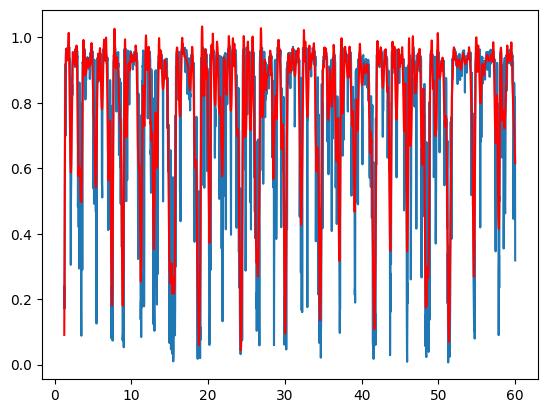

[(1.05, 51.0, 0.0),
 (0.3, 53.0, 200.0),
 (0.5, 51.0, -200.0),
 (0.5, 51.0, 0.0),
 (0.4, 49.0, -200.0),
 (0.5, 48.0, -100.0),
 (0.5, 48.0, 0.0),
 (0.5, 49.0, 100.0),
 (0.5, 49.0, 0.0),
 (0.5, 51.0, 200.0),
 (0.5, 51.0, 0.0),
 (0.025, 49.0, -200.0),
 (0.5, 48.0, -100.0),
 (0.5, 48.0, 0.0),
 (0.5, 51.0, 300.0),
 (0.5, 51.0, 0.0),
 (0.475, 53.0, 200.0),
 (0.5, 51.0, -200.0),
 (0.5, 51.0, 0.0),
 (0.5, 48.0, -300.0),
 (0.5, 48.0, 0.0),
 (0.5, 53.0, 500.0),
 (0.5, 53.0, 0.0),
 (0.5, 49.0, -400.0),
 (0.5, 49.0, 0.0),
 (0.125, 52.0, 300.0),
 (0.1, 53.0, 100.0),
 (0.425, 52.0, -100.0),
 (0.475, 51.0, -100.0),
 (0.1, 52.0, 100.0),
 (0.175, 51.0, -100.0),
 (0.5, 49.0, -200.0),
 (0.5, 49.0, 0.0),
 (0.5, 46.0, -300.0),
 (0.5, 46.0, 0.0),
 (0.5, 51.0, 500.0),
 (0.5, 51.0, 0.0),
 (0.05, 56.0, 500.0),
 (0.5, 57.0, 100.0),
 (0.5, 57.0, 0.0),
 (0.5, 53.0, -400.0),
 (0.5, 53.0, 0.0),
 (0.075, 54.0, 100.0),
 (0.375, 53.0, -100.0),
 (0.025, 56.0, 300.0),
 (0.5, 57.0, 100.0),
 (0.5, 57.0, 0.0),
 (0.5, 51.0,

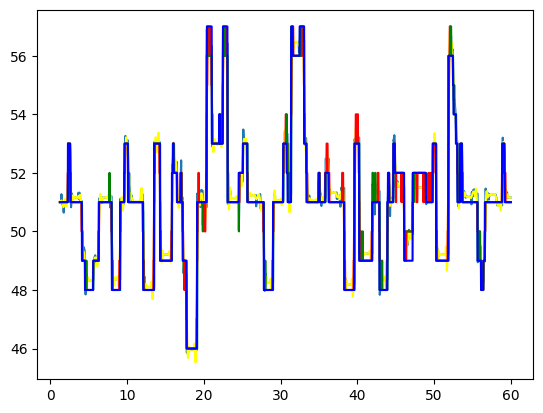

In [786]:
import librosa 
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

def filter_data(time, frequency, confidence):
    data = tuple(data for data in zip(list(time), list(frequency), list(confidence)) if data[2] > 0.1)
    dev = 0
    dur = 0
    for (p1, p2) in pairwise(data):
        t_diff = (p2[0] - p1[0])
        dur = round(dur + (p2[0] - p1[0]), 2)
        if(True):
            freq1, conf1 = p1[1:3]
            midi1 = librosa.hz_to_midi(freq1)
            r_midi1 = np.around(midi1)
            freq2, conf2 = p2[1:3]
            midi2 = librosa.hz_to_midi(freq2)
            r_midi2 = np.around(midi2)
            #if(r_midi2 != r_midi1):
            if(True):
                yield(dur, freq1, conf1, midi1, r_midi1, dev * 100)
                dev = r_midi2 - r_midi1
                dur = 0
                
def filter_data(time, frequency, confidence):
    data = tuple(data for data in zip(list(time), list(frequency), list(confidence)) if data[2] > 0.9)
    #durs = tuple(round(y[0]-x[0], 2) for (x, y) in pairwise(data)) + ((1,))
    #data = tuple((d,) + data[i][1:] for i, d in enumerate(durs) if d > 0.01)
    #print(data)
    m, rm = [librosa.hz_to_midi(data[0][1]), np.around(librosa.hz_to_midi(data[0][1]))]
    yield(data[0] + (m, rm, 0,))
    for i, [t, f, c] in enumerate(data):
        nm, nrm = [librosa.hz_to_midi(f), np.around(librosa.hz_to_midi(f))]
        if((0 < i < len(data) - 1) and (nrm != rm)):
            m, rm, d = [nm, nrm, nrm - rm]
            yield(t, f, c, m, rm, d * 100)
            
t_min = 50
t_max = 600
f_time, f_frequency, f_confidence = [time[t_min:], frequency[t_min:], confidence[t_min:]]
s_confidence = savgol_filter(f_confidence, 30, 4)
plt.plot(f_time, f_confidence)
plt.plot(f_time, s_confidence, color='red')
plt.show()

def filter_midi(f_time, f_frequency, s_confidence):
    last_confident_value = 51
    for t, f, c in zip(f_time, f_frequency, s_confidence):
        if c > 0.9:
            last_confident_value = librosa.hz_to_midi(f)
        yield last_confident_value
            
#m_time, midi = zip(*[[t, librosa.hz_to_midi(f)] for t, f, c in zip(f_time, f_frequency, s_confidence) if c > 0.0])
#nr_midi = np.interp(f_time, m_time, midi)
#r_midi = np.interp(f_time, m_time, np.around(midi))
#midi

midi = list(filter_midi(f_time, f_frequency, s_confidence))

def snap_midi(midi):
    r_midi = np.around(midi)
    s_midi = np.around(savgol_filter(midi, 30, 5))
    last_val = s_midi[0]
    for i, (r1, r2) in enumerate(pairwise(r_midi)):
        if r1 != r2:
            last_val = s_midi[i+5]
        yield last_val
    yield last_val

def filter_midi(midi):
    last_val = midi[0]
    dur = 1
    dev = 0.0
    first_flag = True
    for i, (m1, m2) in enumerate(pairwise(midi)):
        if m1 != m2:
            #yield (dur / 40, last_val, dev * 100)
            if first_flag or dur < 20:
                yield (dur / 40, last_val, dev * 100)
                first_flag = False
            else:
                size = int(dur / 20)
                yield (20 / 40.0, last_val, dev * 100)
                yield (20 / 40.0, last_val, 0.0)
            last_val = m2
            dur = 1
            dev = m2 - m1
        else:
            dur += 1
            
    

plt.plot(f_time, midi)
plt.plot(f_time, savgol_filter(midi, 30, 5), color='yellow')
plt.plot(f_time, np.around(savgol_filter(midi, 30, 5)), color='red')
plt.plot(f_time, np.around(midi), color='green')
plt.plot(f_time, list(snap_midi(midi)), color='blue')
#plt.show()

target_melody_data = list(filter_midi(list(snap_midi(midi))))
target_melody_data

#target_melody_data = list(filter_data(time, frequency, confidence))
#target_melody_data
#durs = tuple(round(y[0]-x[0], 2) for (x, y) in pairwise(target_melody_data)) + ((1,))
#print(durs)
#target_melody_data = tuple((d,) + target_melody_data[i][1:] for i, d in enumerate(durs) if d > 0.1)
#list(target_melody_data)

In [750]:
1/0.025

40.0

In [822]:
from random import choice, choices

# This is for the beginning / breysheet
def stochastic_hamiltonian(graph):

    #try making this omit the moving voice
    def movement_size_weights(edges):
        
        def max_cent_diff(edge):
            res = max([abs(v) for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None])
            return res
            
        def min_cent_diff(edge):
            res = [abs(v) for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None]
            res.remove(0)
            return min(res)
            
        for e in edges:
            yield 200 if ((max_cent_diff(e) < 100) and (min_cent_diff(e)) >= 0) else 1

    def hamiltonian_weights(edges):
        for e in edges:
            yield 10 if e[1] not in [path_edge[0] for path_edge in path] else 1 / graph.nodes[e[1]]['count']
    
    def contrary_motion_weights(edges):

        def is_contrary(edge):
            cent_diffs = [v for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None]
            cent_diffs.sort()
            return (cent_diffs[0] < 0) and (cent_diffs[1] == 0) and (cent_diffs[2] > 0)

        for e in edges:
            yield 2 if is_contrary(e) else 1
    
    def is_directly_tunable_weights(edges):
        for e in edges:
            yield 10 if e[2]['is_directly_tunable'] else 1

    def symdiff_weights(edges):
        for e in edges:
            yield 1000 if e[2]['symmetric_difference'] == 2 else 1

    def transposition_weight(edges):
        for e in edges:
            yield 100 if 0 <= hs_array_to_cents(e[2]['transposition']) < 100 else 1

    def is_sustained_voice(edges, voice):
        
        def is_sustained(edge):
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_array_to_fr)    
            destination = [transpose_pitch(edge[2]['movements'][p]['destination'], edge[2]['transposition']) for p in source]
            ordered_destination = sorted(destination, key=hs_array_to_fr)
            return ordered_source[voice] == ordered_destination[voice]

        for e in edges:
            yield 10 if is_sustained(e) else 1

    def voice_crossing_weights(edges):
        
        def has_voice_crossing(edge):
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_array_to_fr)    
            source_order = [ordered_source.index(p) for p in source]
            destination = [transpose_pitch(edge[2]['movements'][p]['destination'], edge[2]['transposition']) for p in source]
            ordered_destination = sorted(destination, key=hs_array_to_fr)
            destination_order = [ordered_destination.index(p) for p in destination]
            return source_order != destination_order

        for e in edges:
            yield 10 if not has_voice_crossing(e) else 0

    def is_bass_rooted(chord):
        return max([sum(abs(p) for p in collapse_pitch(pitch_difference(chord[0], p))) for p in chord[1:]]) == 1

    def target_melody_weights(edges, target, c_devs, voice):

        def target_weight(edge, target, c_devs, voice):
            candidate_diffs = []
            for idx, dev in enumerate(c_devs):
                if(idx == 2):
                    source = list(edge[0])
                    ordered_source = sorted(source, key=hs_array_to_fr)    
                    candidate_diff = edge[2]['movements'][ordered_source[idx]]['cent_difference']
                    candidate_diffs += [abs(dev + candidate_diff - target)]
            #return 1/pow(1.1, min(candidate_diffs))
            return 1 if min(candidate_diffs) < 40 else 1/pow(1.1, min(candidate_diffs))
            
        for e in edges:
            yield target_weight(e, target, c_devs, voice)
        
    check_graph = graph.copy()
    next_node = choice(list(graph.nodes()))
    check_graph.remove_node(next_node)
    for node in graph.nodes(data=True):
        node[1]['count'] = 1
    path = []
    s_next_node = sorted(next_node, key=hs_array_to_fr)
    c_devs = (cent_difference(s_next_node[2], s_next_node[0]), cent_difference(s_next_node[2], s_next_node[1]), 0,)
    #c_devs = (0, cent_difference(s_next_node[0], s_next_node[1]), cent_difference(s_next_node[0], s_next_node[2]),)
    print(c_devs)
    while (nx.number_of_nodes(check_graph) > 0) and (len(path) < len(target_melody_data)-1):
        out_edges = list(graph.out_edges(next_node, data=True))
        factors = [
            movement_size_weights(out_edges), 
            hamiltonian_weights(out_edges), 
            contrary_motion_weights(out_edges), 
            is_directly_tunable_weights(out_edges),
            voice_crossing_weights(out_edges),
            #transposition_weight(out_edges),
            #is_sustained_voice(out_edges, 0),
            target_melody_weights(out_edges, target_melody_data[len(path)+1][-1], c_devs, 2),
            symdiff_weights(out_edges)
        ]
        weights = [prod(a) for a in zip(*factors)]
        edge = choices(out_edges, weights=weights)[0]
        next_node = edge[1]
        node[1]['count'] += 1
        path.append(edge)
        s_chord = tuple(sorted(edge[0], key=hs_array_to_fr))
        c_devs = tuple(c_devs[pdx] + edge[2]['movements'][pitch]['cent_difference'] - target_melody_data[len(path)][-1] for pdx, pitch in enumerate(s_chord))
        print(c_devs)
        if next_node in check_graph.nodes:
            check_graph.remove_node(next_node)
    return path

In [824]:
dims = (2, 3, 5, 7, 11, 13)
root = (0, 0, 0, 0, 0, 0)
chord = (root,)
chord_set = chords(chord, root, 3, 3)
graph = generate_graph(chord_set, 4, 4, 3)

In [825]:
path = stochastic_hamiltonian(graph)
#durs = tuple(round(y[0]-x[0], 2) for (x, y) in pairwise(target_melody_data)) + ((1,))
durs = tuple(d[0] for d in target_melody_data)
path_to_chords(path, root)
write_chord_sequence(list(zip(durs, path_to_chords(path, root))))

(-359.4723382306895, -231.17409353087487, 0)
(-929.2190926654878, -431.17409353087487, -44.86037966604022)
(-729.2190926654878, -177.9011503007306, -27.26409180010012)
(-826.5832079359744, -177.9011503007306, -12.896921800808741)
(-626.5832079359744, -240.26949407113915, -9.09540054026445)
(-526.5832079359744, -206.43935910209234, 24.734734428782644)
(-526.5832079359744, -167.11086970528447, -28.538208801361634)
(-1107.6385314745955, -267.1108697052845, -35.936776174409715)
(-1004.7626826435351, -587.2547185391661, -35.936776174409715)
(-1018.4288120700417, -787.2547185391661, 26.431567595998786)
(-942.3943388731266, -814.0960941733115, 26.431567595998786)
(-742.3943388731266, -511.22024534225113, -13.175246207638565)
(-642.3943388731266, -353.1846194685721, 6.287718762117265)
(-712.6569576992622, -353.1846194685721, 33.12909439626287)
(-1151.2296186031854, -653.1846194685721, -4.5025618333286275)
(-1107.138446562843, -555.8205041980855, -4.5025618333286275)
(-986.9945977289614, -755.8